In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# import statsmodels.api as sm
# from statsmodels.tsa.seasonal import seasonal_decompose
# from scipy import stats

In [25]:
# Setting hyperparameters
batch_size = 64
epochs = 15
learning_rate = 0.00001
hidden_shape = 256
num_layer = 2
l1 = False
l2 = False
lr_decay = False

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


# path = 'drive/MyDrive/code/bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
path = "bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

In [4]:
df1 = pd.read_csv(path)

# df = df1.dropna(how="any")

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [5]:
df1['Volume_(BTC)'].fillna(value=0, inplace=True)
df1['Volume_(Currency)'].fillna(value=0, inplace=True)
df1['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
df1['Open'].fillna(method='ffill', inplace=True)
df1['High'].fillna(method='ffill', inplace=True)
df1['Low'].fillna(method='ffill', inplace=True)
df1['Close'].fillna(method='ffill', inplace=True)

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [6]:
# s = df1["Weighted_Price"].copy(True)
# # df1_diff = s.diff(periods=60*24*365)
# # df1_diff = s.diff(periods=5)
# plt.figure(figsize=(8, 6))
# plt.plot(s)

In [7]:
# rolling_mean = s.rolling(window = 60*24*365).mean()
# s_rolled_detrended = s - rolling_mean
# plt.figure(figsize=(8, 6))
# plt.plot(s_rolled_detrended[60*24*365+1:])

### Un-detrended data

In [8]:
# Generating dataset

class bitcoin(Dataset):
    def __init__(self, X, window):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window-1
        # print(self.len)
        for i in range(0, X.shape[0]-window-1):
          self.X.append(X[i:window+i])
          self.y.append(X[window+i])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # print(index)
        # print(self.X[index])
        # print(self.y[index])
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [9]:
scaler = MinMaxScaler()
scaler.fit(df1["Weighted_Price"].to_numpy().reshape(-1, 1))
data = scaler.transform(df1["Weighted_Price"].to_numpy().reshape(-1, 1))

In [10]:
# Sequence lenght is 60.
window = 60

In [11]:
train = bitcoin(data.squeeze()[2400000:4500000], window)

In [12]:
val = bitcoin(data.squeeze()[4500000:4750000], window)

In [13]:
test = bitcoin(data.squeeze()[4750000:4800000], window)

In [14]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [15]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([64, 60]) torch.Size([64, 1])


In [16]:
class RNNForecasting(nn.Module):
    def __init__(self, seq_length, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_shape * seq_length, output_shape)

    def forward(self, x):
        batch_size = x.size(0)
        h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
        # h = torch.zeros([self.num_layers, batch_size, self.hidden])
        out, h = self.rnn(x, h)
        out = self.linear(out.contiguous().view(out.shape[0], -1))

        return out

    def compute_l1(self, w):
        return torch.abs(w).sum()

    def compute_l2(self, w):
      return torch.square(w).sum()

In [17]:
# Test model,
input_shape = 1
output_shape = 1
test = RNNForecasting(window, input_shape, hidden_shape, output_shape, num_layer).cuda()
# (seq,btch,in_sh)
out = test(features.unsqueeze(2).cuda())
print(out.shape)

torch.Size([64, 1])


In [18]:
input_shape = 1
model = RNNForecasting(window, input_shape, hidden_shape, 1, num_layers=num_layer).cuda()
# model = RNNForecasting(window, input_shape, hidden_shape, 1, num_layers=num_layer)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

In [20]:
# Training
l1_weight = 0.01
l2_weight = 0.01
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        l = criterion(y_pred, batch_y)

    #     # Using l1 regularization
    #     if l1:
    #         l1_parameters = []
    #         for parameter in model.parameters():
    #             l1_parameters.append(parameter.view(-1))
    #         L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
    #         l += L1

    #     # Using l2 regularization
    #     if l2:
    #         l2_parameters = []
    #         for parameter in model.parameters():
    #             l2_parameters.append(parameter.view(-1))
    #         L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
    #         l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)

Epoch:  0 train:  0.015235487055344926 val:  0.1255881244598856
Epoch:  1 train:  0.015099581148955779 val:  0.10909053529754868
Epoch:  2 train:  0.014940178760995062 val:  0.08759738960742915
Epoch:  3 train:  0.014807787964476531 val:  0.07355293591744934
Epoch:  4 train:  0.01474298835725819 val:  0.06689278621426321
Epoch:  5 train:  0.014711271583022037 val:  0.0633490476512452
Epoch:  6 train:  0.014692947998101861 val:  0.06173810774757856
Epoch:  7 train:  0.01468117572040132 val:  0.06038847641894743
Epoch:  8 train:  0.01467258603617429 val:  0.05941924913171872
Epoch:  9 train:  0.014664972493096071 val:  0.05809335835043394
Epoch:  10 train:  0.014659543173548758 val:  0.05744771331953622
Epoch:  11 train:  0.014655477081180293 val:  0.056931973897849146
Epoch:  12 train:  0.014651080029174606 val:  0.05624232735204946
Epoch:  13 train:  0.014647610978520966 val:  0.05612214340561614
Epoch:  14 train:  0.014644436167311035 val:  0.05566225818731917
Epoch:  15 train:  0.014

In [21]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.unsqueeze(2)
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))
        # preds.append(scaler.inverse_transform(output.detach().numpy()))
        # true.append(scaler.inverse_transform(batch_y.detach().numpy()))
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)
    # 120811220.0 10695.036

100777690.0 9751.7295


In [22]:
preds.shape, true.shape

((49939, 1), (49939, 1))

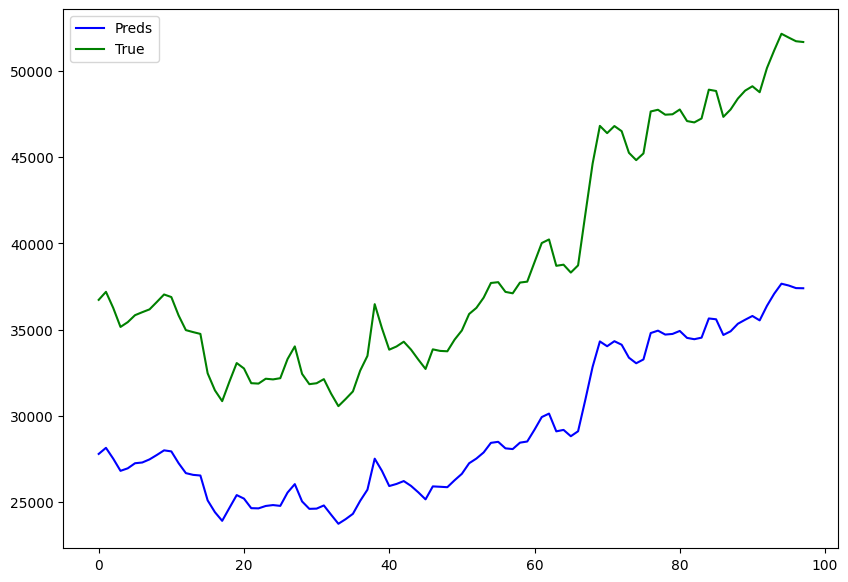

In [23]:
preds_reshaped = preds[939:].reshape(-1, 500)
true_reshaped = true[939:].reshape(-1, 500)

preds_avg = np.mean(preds_reshaped, axis=1)
true_avg = np.mean(true_reshaped, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(preds_avg, 'b', label='Preds')
plt.plot(true_avg, 'g', label='True')
plt.legend()
plt.show()

In [26]:
# Creating/updating config file with hyperparameters and model performance
import os
from pathlib import Path
import json

filepath = "config/config.json"
filepath = Path(filepath)
filedir, filename = os.path.split(filepath)

dic = {
    "model": "RNN",
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "hidden_shape": hidden_shape,
    "num_layer": num_layer,
    "l1": l1,
    "l2": l2,
    "lr_decay": lr_decay,
    "MAE": str(mae),
    "MSE": str(mse)
}

# Serializing json
json_object = json.dumps(dic, indent=4)

if filedir != "":
    os.makedirs(filedir, exist_ok=True)
    print(f"Creating directory:{filedir} for the file {filename}")

    
if (not os.path.exists(filepath)) or (os.path.getsize(filepath) == 0):
    # size!=0 means there is content in the file, so do not replace with write operation.
    with open(filepath,'w') as f:
        f.write(json_object, f, indent=4)
        print("New config file is created with first configuration for the model")

else:
    with open(filepath,'a') as f:
        f.write(json_object, f, indent=4)
        print("New configuration for the model added")

Creating directory:config for the file config.json
New configuration for the model added


### Detrended data

In [ ]:
interval = 60*24*365
transformed_train = df1["Weighted_Price"].diff(interval)

scaler = MinMaxScaler((-1,1))
scaler.fit(transformed_train[interval+1:].to_numpy().reshape(-1, 1))
data = scaler.transform(transformed_train[interval+1:].to_numpy().reshape(-1, 1))

In [ ]:
train = bitcoin(data.squeeze()[:3700000], 5)
val = bitcoin(data.squeeze()[3700000:3750000], 5)
test = bitcoin(data.squeeze()[3750000:3800000], 5)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

In [ ]:
input_shape = 5
model = RNNForecasting(input_shape, hidden_shape, 1, num_layers=3).cuda()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

In [ ]:
# Training
l1_weight = 0.01
l2_weight = 0.01
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # print(batch_x.dtype)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        if l1:
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
            l += L1

        # Using l2 regularization
        if l2:
            l2_parameters = []
            for parameter in model.parameters():
                l2_parameters.append(parameter.view(-1))
            L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
            l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    if lr_decay:
        epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Iter: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)

In [ ]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))
    preds = np.concatenate(preds)
    true = np.concatenate(true)

In [ ]:
true = true + data.squeeze()[3750000-(60*24*365):3800000-(60*24*365)]
preds = preds + data.squeeze()[3750000-(60*24*365):3800000-(60*24*365)]

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

print(mse, mae)
n = 250
plt.figure(figsize=(8, 6))
plt.plot(preds[::n], 'b', label='line 1')
plt.plot(true[::n], 'g',  label='line 2')
plt.show()